In [4]:
import csv
import json
import sys
from datetime import datetime
from pathlib import Path
from typing import List, Dict, Set

def load_json(file_path):
    """
    Load a JSON file and return its content as a Python dictionary.

    :param file_path: Path to the JSON file.
    :return: Dictionary containing the JSON data.
    """
    with open(file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)
    return data

## Reading data

In [5]:
data = load_json('../data/MC3_graph.json')
schema = load_json('../data/MC3_schema.json')

In [3]:
nodes_type = schema['schema']['nodes'].keys()

## Parsing data for PAOHVIS

In [7]:
def collect_entity_names(nodes: List[Dict]) -> Set[str]:
    """Return a set with the *unique* names of all entities."""
    return {n["name"] for n in nodes if n.get("type") == "Entity"}

def extract_time_slot(raw_ts: str) -> str:
    """Convert full timestamp to a coarse *time‑slot* accepted by PAOHVis.

    Currently we keep the **date** part (`YYYY‑MM‑DD`). If `raw_ts` is null or
    malformed, we return "unknown" so the record still loads.
    """
    if not raw_ts:
        return "unknown"
    try:
        return datetime.fromisoformat(raw_ts).date().isoformat()
    except ValueError:
        return raw_ts
    
def detect_participants(content: str, entity_names: Set[str]) -> Set[str]:
    """Return the subset of `entity_names` that occur inside `content`."""
    participants = {name for name in entity_names if name in content}
    return participants

In [8]:
nodes = data.get("nodes", [])
edges = data.get("edges", [])
entity_names = collect_entity_names(nodes)

In [9]:
len(entity_names)

72

In [ ]:
# Create a CSV file with the required columns
output_file = '../data/MC3_data_parsed.csv'
with open(output_file, 'w', newline='', encoding='utf-8') as csvfile:
    fieldnames = ['edge_id', 'node_name', 'time_slot', 'edge_name_description', 'group_name', 'role']
    writer = csv.writer(csvfile)
    writer.writerow(fieldnames)
    for event in nodes:
            if event.get("type") == "Event" and event.get("sub_type") == "Communication":
                edge_id = event.get("id")
                time_slot = extract_time_slot(event.get("timestamp"))
                content = event.get("content", "")
                # A short description—trim content to first 60 chars
                edge_desc = content[:60] + ("…" if len(content) > 60 else "")

                participants = detect_participants(content, entity_names)
                if not participants:
                    # Fallback: unknown sender/receiver – still output a single row
                    writer.writerow([edge_id, "_unknown_", time_slot, edge_desc, "", ""])
                else:
                    for name in participants:
                        writer.writerow([edge_id, name, time_slot, edge_desc, "", ""])
print(f"Data parsed and saved to {output_file}")

In [17]:
edges

[{'id': '2',
  'is_inferred': True,
  'source': 'Sam',
  'target': 'Relationship_Suspicious_217'},
 {'id': '3',
  'type': 'sent',
  'is_inferred': False,
  'source': 'Sam',
  'target': 'Event_Communication_370'},
 {'id': '5',
  'is_inferred': True,
  'source': 'Sam',
  'target': 'Event_Assessment_600'},
 {'id': '3013',
  'is_inferred': True,
  'source': 'Sam',
  'target': 'Relationship_Colleagues_430'},
 {'is_inferred': True, 'source': 'Sam', 'target': 'Relationship_Friends_272'},
 {'is_inferred': True,
  'source': 'Sam',
  'target': 'Relationship_Colleagues_215'},
 {'is_inferred': True,
  'source': 'Sam',
  'target': 'Relationship_Colleagues_431'},
 {'id': '8',
  'type': 'sent',
  'is_inferred': False,
  'source': 'Kelly',
  'target': 'Event_Communication_3'},
 {'id': '10',
  'type': 'sent',
  'is_inferred': False,
  'source': 'Kelly',
  'target': 'Event_Communication_443'},
 {'is_inferred': True,
  'source': 'Kelly',
  'target': 'Relationship_Friends_272'},
 {'is_inferred': True,
  '

## Question 3

1. Expanding upon your prior visual analytics, determine who is using pseudonyms to communicate, and what these pseudonyms are.
2. Describe how your visualization makes it easier to identify common entities in the data.
3. How does your understanding of activities change given your understanding of pseudonyms

In [10]:
import numpy as np
import pandas as pd

In [12]:
def cosine(u: np.ndarray, v: np.ndarray) -> float:
    """Cosine similarity for 1‑D row vectors"""
    return float(np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v)))

In [13]:
def get_participants_communications(event_id: str, nodes, edges):
    sent_edge = next((e for e in edges if e.get('type') == 'sent' and e.get('target') == event_id), None)
    # Find the 'received' edge where source is the event
    received_edge = next((e for e in edges if e.get('type') == 'received' and e.get('source') == event_id), None)

    if not sent_edge or not received_edge:
        return None, None

    source_entity_id = sent_edge['source']
    target_entity_id = received_edge['target']

    source_node = next((n for n in nodes if n.get('id') == source_entity_id), None)
    target_node = next((n for n in nodes if n.get('id') == target_entity_id), None)

    return source_node, target_node


In [14]:
print("[+] Loading graph …")
messages = []
for event in nodes:
    if event.get("type") == "Event" and event.get("sub_type") == "Communication": # We concentrate on the communications
        event_id = event.get("id")
        time_slot = event.get("timestamp")
        content = event.get("content", "")
        participants = get_participants_communications(event_id, nodes, edges)
        messages.append(
            {
                "event_id": event_id,
                "datetime": time_slot,
                "content": content,
                "source": participants[0],
                "target": participants[1] 
            }
        )
        

[+] Loading graph …


In [15]:
len(messages)

584

In [16]:
messages_df = pd.DataFrame(messages)

In [17]:
messages_df['word_count'] = messages_df['content'].apply(lambda x: len(x.split()))

In [18]:
messages_df

,event_id,datetime,content,source,target,word_count
0,Event_Communication_1,2040-10-01 08:09:00,"Hey The Intern, it's The Lookout! Just spotted...","{'type': 'Entity', 'label': 'The Lookout', 'na...","{'type': 'Entity', 'label': 'The Intern', 'nam...",46
1,Event_Communication_2,2040-10-01 08:10:00,"Hey The Lookout, The Intern here! I'd absolute...","{'type': 'Entity', 'label': 'The Intern', 'nam...","{'type': 'Entity', 'label': 'The Lookout', 'na...",37
2,Event_Communication_3,2040-10-01 08:13:00,"Sam, it's Kelly! Let's meet at Sunrise Point a...","{'type': 'Entity', 'label': 'Kelly', 'name': '...","{'type': 'Entity', 'label': 'Sam', 'name': 'Sa...",34
3,Event_Communication_5,2040-10-01 08:16:00,"Mrs. Money, it's The Intern. Just checking in ...","{'type': 'Entity', 'label': 'The Intern', 'nam...","{'type': 'Entity', 'label': 'Mrs. Money', 'nam...",35
4,Event_Communication_6,2040-10-01 08:19:00,"Boss, it's Mrs. Money. I've reviewed our opera...","{'type': 'Entity', 'label': 'Mrs. Money', 'nam...","{'type': 'Entity', 'label': 'Boss', 'name': 'B...",31
...,...,...,...,...,...,...
579,Event_Communication_994,2040-10-14 12:50:00,"Green Guardians, Oceanus City Council here. Yo...","{'type': 'Entity', 'label': 'Oceanus City Coun...","{'type': 'Entity', 'label': 'Green Guardians',...",36
580,Event_Communication_997,2040-10-14 12:51:00,"EcoVigil, Green Guardians HQ here. Your video ...","{'type': 'Entity', 'label': 'Green Guardians',...","{'type': 'Entity', 'label': 'EcoVigil', 'name'...",39
581,Event_Communication_999,2040-10-14 13:31:00,Defender to Mako. Be advised that conservation...,"{'type': 'Entity', 'label': 'Defender', 'name'...","{'type': 'Entity', 'label': 'Mako', 'name': 'M...",34
582,Event_Communication_1001,2040-10-14 13:34:00,"Knowles, Mako here. Proceed to southern dock a...","{'type': 'Entity', 'label': 'Knowles', 'name':...","{'type': 'Entity', 'label': 'Davis', 'name': '...",37


In [38]:
mean_word_count = messages_df['word_count'].mean()
print(f"Mean word count in messages: {mean_word_count:.2f}")

Mean word count in messages: 35.53


## Generating Embeddings using Local model

In [20]:
import torch
print(torch.cuda.is_available())

True


In [21]:
from sentence_transformers import SentenceTransformer
from tqdm import tqdm

In [22]:
MODEL_NAME  = "intfloat/e5-large-v2"
DEVICE      = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE  = 128      

In [23]:
encoder = SentenceTransformer(MODEL_NAME, device=DEVICE)

modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/67.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/201 [00:00<?, ?B/s]

In [24]:
def embed_messages(messages: List[Dict],
                   key: str = "embedding") -> List[Dict]:
    """
    Adds a GPU-generated 1024-d embedding under messages[i][key].
    Runs fully offline.
    """
    texts = [m["content"] for m in messages]

    # E5 models expect 'query: ' or 'passage: ' prefixes – use passage mode
    texts = [f"passage: {t}" for t in texts]

    vectors = encoder.encode(
        texts,
        batch_size=BATCH_SIZE,
        normalize_embeddings=True,
        show_progress_bar=True
    )

    for msg, vec in zip(messages, vectors):
        msg[key] = vec.tolist()        # keep JSON-serialisable

    return messages

In [25]:
messages_with_embeddings = embed_messages(messages)

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

In [28]:
messages_df = pd.DataFrame(messages)
messages_df.head(10)

,event_id,datetime,content,source,target,embedding
0,Event_Communication_1,2040-10-01 08:09:00,"Hey The Intern, it's The Lookout! Just spotted...","{'type': 'Entity', 'label': 'The Lookout', 'na...","{'type': 'Entity', 'label': 'The Intern', 'nam...","[0.029241979122161865, -0.041862864047288895, ..."
1,Event_Communication_2,2040-10-01 08:10:00,"Hey The Lookout, The Intern here! I'd absolute...","{'type': 'Entity', 'label': 'The Intern', 'nam...","{'type': 'Entity', 'label': 'The Lookout', 'na...","[0.03175385668873787, -0.05981289967894554, 0...."
2,Event_Communication_3,2040-10-01 08:13:00,"Sam, it's Kelly! Let's meet at Sunrise Point a...","{'type': 'Entity', 'label': 'Kelly', 'name': '...","{'type': 'Entity', 'label': 'Sam', 'name': 'Sa...","[0.017817020416259766, -0.04965541884303093, 0..."
3,Event_Communication_5,2040-10-01 08:16:00,"Mrs. Money, it's The Intern. Just checking in ...","{'type': 'Entity', 'label': 'The Intern', 'nam...","{'type': 'Entity', 'label': 'Mrs. Money', 'nam...","[0.02555183693766594, -0.039673373103141785, -..."
4,Event_Communication_6,2040-10-01 08:19:00,"Boss, it's Mrs. Money. I've reviewed our opera...","{'type': 'Entity', 'label': 'Mrs. Money', 'nam...","{'type': 'Entity', 'label': 'Boss', 'name': 'B...","[0.03286131098866463, -0.037319015711545944, -..."
5,Event_Communication_7,2040-10-01 08:21:00,"Mrs. Money, this is Boss. I'm available tomorr...","{'type': 'Entity', 'label': 'Boss', 'name': 'B...","{'type': 'Entity', 'label': 'Mrs. Money', 'nam...","[0.019072681665420532, -0.05098644644021988, 0..."
6,Event_Communication_8,2040-10-01 08:24:00,"Boss, Mrs. Money here. I'll bring the updated ...","{'type': 'Entity', 'label': 'Mrs. Money', 'nam...","{'type': 'Entity', 'label': 'Boss', 'name': 'B...","[0.016821149736642838, -0.06205496937036514, 0..."
7,Event_Communication_9,2040-10-01 08:26:00,"Middleman, this is Boss. I'd like to move our ...","{'type': 'Entity', 'label': 'Boss', 'name': 'B...","{'type': 'Entity', 'label': 'The Middleman', '...","[0.040154945105314255, -0.04691818356513977, 0..."
8,Event_Communication_10,2040-10-01 08:29:00,"Boss, this is The Middleman. I can meet earlie...","{'type': 'Entity', 'label': 'The Middleman', '...","{'type': 'Entity', 'label': 'Boss', 'name': 'B...","[0.03250553831458092, -0.039654843509197235, 0..."
9,Event_Communication_11,2040-10-01 08:32:00,"Middleman, this is Boss. Let's meet tomorrow a...","{'type': 'Entity', 'label': 'Boss', 'name': 'B...","{'type': 'Entity', 'label': 'The Middleman', '...","[0.0183577798306942, -0.056135762482881546, 0...."


In [30]:
import collections, numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd, torch

by_alias = collections.defaultdict(list)
for m in messages:
    by_alias[m["source"]["id"]].append(np.asarray(m["embedding"]))

aliases  = sorted(by_alias)
centroid = {a: np.mean(by_alias[a], axis=0) for a in aliases}

X = torch.tensor(np.stack([centroid[a] for a in aliases]), device=DEVICE)
sim = torch.nn.functional.linear(X, X)        # since vectors are normalised
sim = sim.cpu().numpy()


In [31]:
cosine_similarities = pd.DataFrame(sim, index=aliases, columns=aliases)

In [32]:
cosine_similarities

,Boss,Clepper Jensen,Davis,Defender,EcoVigil,Elise,Glitters Team,Green Guardians,Haacklee Harbor,Himark Harbor,...,Samantha Blake,Seawatch,Sentinel,Serenity,Small Fry,The Accountant,The Intern,The Lookout,The Middleman,V. Miesel Shipping
Boss,0.892404,0.826156,0.828403,0.821173,0.818751,0.854844,0.824676,0.825230,0.805693,0.806743,...,0.845548,0.819515,0.827401,0.819785,0.822872,0.854250,0.844628,0.823440,0.872785,0.819074
Clepper Jensen,0.826156,0.893128,0.820626,0.804127,0.816558,0.834352,0.811393,0.809855,0.784985,0.783374,...,0.815004,0.808666,0.819460,0.801726,0.812498,0.824249,0.829898,0.814275,0.822665,0.805296
Davis,0.828403,0.820626,0.861588,0.814032,0.808804,0.838869,0.820145,0.816217,0.816688,0.825262,...,0.828982,0.814975,0.827349,0.816081,0.842160,0.823489,0.824476,0.816057,0.821467,0.833838
Defender,0.821173,0.804127,0.814032,0.918843,0.830943,0.824660,0.796905,0.851725,0.806029,0.810999,...,0.831385,0.846221,0.843474,0.831269,0.795030,0.809535,0.811778,0.833220,0.804296,0.803922
EcoVigil,0.818751,0.816558,0.808804,0.830943,0.870974,0.828591,0.818952,0.845259,0.799336,0.793792,...,0.831677,0.840998,0.838541,0.811208,0.806622,0.816089,0.819733,0.829680,0.813711,0.795728
Elise,0.854844,0.834352,0.838869,0.824660,0.828591,0.922203,0.828031,0.835331,0.813056,0.807180,...,0.857542,0.828621,0.839892,0.826511,0.827977,0.861693,0.852300,0.829184,0.851836,0.841074
Glitters Team,0.824676,0.811393,0.820145,0.796905,0.818952,0.828031,0.907540,0.816018,0.796574,0.798233,...,0.839620,0.808994,0.821659,0.808772,0.838348,0.811284,0.822510,0.814003,0.816368,0.811158
Green Guardians,0.825230,0.809855,0.816217,0.851725,0.845259,0.835331,0.816018,0.883842,0.806492,0.809744,...,0.840660,0.852026,0.849565,0.819993,0.806495,0.818286,0.817126,0.832283,0.819018,0.806163
Haacklee Harbor,0.805693,0.784985,0.816688,0.806029,0.799336,0.813056,0.796574,0.806492,0.863332,0.821621,...,0.818431,0.806130,0.809576,0.803316,0.800795,0.796736,0.800355,0.803825,0.797637,0.806920
Himark Harbor,0.806743,0.783374,0.825262,0.810999,0.793792,0.807180,0.798233,0.809744,0.821621,0.867193,...,0.813768,0.822182,0.809622,0.819951,0.811477,0.790399,0.798037,0.800742,0.794487,0.813962


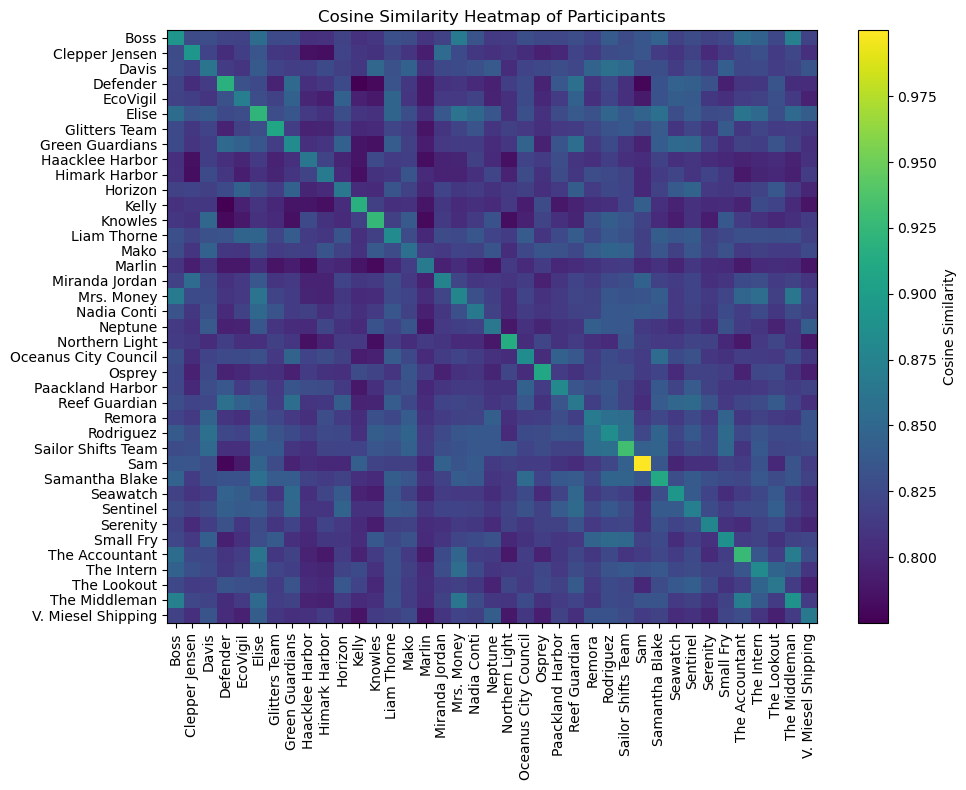

In [33]:
import matplotlib.pyplot as plt
def plot_heatmap(data, title="Cosine Similarity Heatmap"):
    plt.figure(figsize=(10, 8))
    plt.imshow(data, cmap='viridis', aspect='auto')
    plt.colorbar(label='Cosine Similarity')
    plt.title(title)
    plt.xticks(ticks=range(len(data.columns)), labels=data.columns, rotation=90)
    plt.yticks(ticks=range(len(data.index)), labels=data.index)
    plt.tight_layout()
    plt.show()
plot_heatmap(cosine_similarities, title="Cosine Similarity Heatmap of Participants")